In [ ]:
#Install necessary packages
!pip install opencv-python

!pip install pytesseract
!apt install tesseract-ocr -y

!pip install boto3
!pip install google-cloud-vision
!pip install pandas
!pip install matplotlib




In [ ]:
import cv2
import numpy as np
import pytesseract
import boto3
from google.cloud import vision
from google.oauth2 import service_account
import pandas as pd
import matplotlib.pyplot as plt



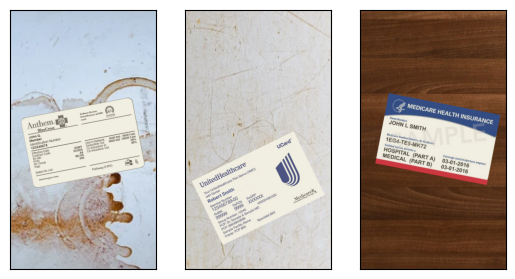

In [ ]:
image_paths = ["/content/image_1.png", "/content/image_2.png", "/content/image_3.png"]
images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in image_paths]

fig, axs = plt.subplots(1, 3)

for i in range(3): axs[i].imshow(images[i])

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()


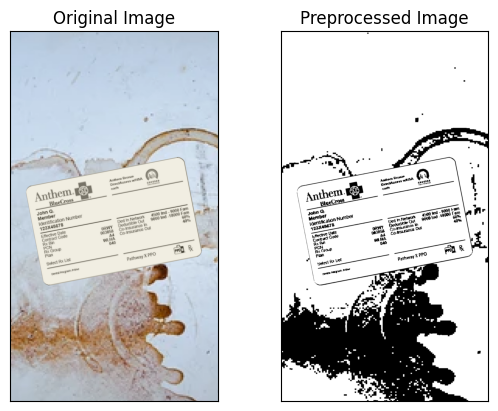

In [ ]:
#Image Preprocessing. AWS Textract and GCP Vision perform pre-processing internally

def preprocess(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    return thresh

preprocessed_images = [preprocess(image) for image in images]

#display the image

fig, axs = plt.subplots(1, 2)
axs[0].imshow(images[0])
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_images[0], cmap='gray')
axs[1].set_title('Preprocessed Image')

# Remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()


In [ ]:
# 3 methods for text extractions

# tesseract
def extract_text_tesseract(image):
    config = "--psm 6"
    text = pytesseract.image_to_string(image, config=config)
    return text

tesseract_results = [extract_text_tesseract(image) for image in preprocessed_images]

# AWS textract
def extract_text_textract(image):
    client = boto3.client('textract', region_name='<YOUR REGION>', aws_access_key_id='<YOUR KEY>', aws_secret_access_key='<YOUR KEY>')
    _, encoded_image = cv2.imencode(".png", image)
    response = client.detect_document_text(Document={'Bytes': encoded_image.tobytes()})
    text = " ".join([item["Text"] for item in response["Blocks"] if item["BlockType"] == "LINE"])
    return text

textract_results = [extract_text_textract(image) for image in preprocessed_images]

# GCP vision
def extract_text_gcloud(image):
    credentials = service_account.Credentials.from_service_account_file('<YOUR JSON FILE PATH')
    client = vision.ImageAnnotatorClient(credentials=credentials)
    _, encoded_image = cv2.imencode('.png', image)
    response = client.document_text_detection(image=vision.Image(content=encoded_image.tobytes()))
    text = response.full_text_annotation.text
    return text

gcloud_results = [extract_text_gcloud(image) for image in preprocessed_images]




In [ ]:
# Display text results
data = {
    "Image": image_paths,
    "Tesseract": tesseract_results,
    "Textract": textract_results,
    "GCP Vision": gcloud_results,
}
df = pd.DataFrame(data)
df

,Image,Tesseract,Textract,GCP Vision
0,/content/image_1.png,.\na er sJs\n_ .\na: hk wtf ier\n* ‘ i\n\ pate...,Anthem. Anthem Bronse DirectAccess WEISA cach ...,Anthem.\nBlueCross\nJohn Q.\nMember\nIdentific...
1,/content/image_2.png,' f\nI ‘\n' a!\nt '\n' :\n' I\n!\n‘ 5\ni ' \\n...,the UnitedHealthcarez UCard™ Your UnitedHealth...,"I\n""\n1\n1\n4\nRXBIN\n99999\nI\nI\n1\nUnitedHe..."
2,/content/image_3.png,"e baler vote eh MT eee\ni.\nJOHN, Suity\nMert:...",MEDICARE HEALTH INSURANCE Name's JOHN L SMITH ...,MEDICARE HEALTH INSURANCE\nName'\nJOHN L SMITH...


In [ ]:
# pull out insurance information from text 

def parse_insurance_card(text):
    extracted_info = {
        'Member Name': '',
        'Member ID': '',
        'Group Number': '',
        'Effective Date': '',
        'Payer ID': '',
        'Rx Bin': '',
        'Rx Grp': '',
        'Rx PCN': '',
        'Health Plan': '',
        'Network': ''
    }

    # Split the text into lines
    lines = text.split('\n')

    for line in lines:
        # Try to split the line into a key and value
        parts = line.split(':')
        if len(parts) < 2:
            continue

        key = parts[0].strip()
        value = parts[1].strip()

        # Check if the key matches any of the keys we're looking for
        if key in extracted_info:
            extracted_info[key] = value

    return extracted_info

tesseract_parsed = [parse_insurance_card(text) for text in tesseract_results]
textract_parsed = [parse_insurance_card(text) for text in textract_results]
gcloud_parsed = [parse_insurance_card(text) for text in gcloud_results]

data = {
    "Image": image_paths,
    "Tesseract": tesseract_parsed,
    "Textract": textract_parsed,
    "GCP Vision": gcloud_parsed,
}
df = pd.DataFrame(data)
df


,Image,Tesseract,Textract,GCP Vision
0,/content/image_1.png,"{'Member Name': '', 'Member ID': '', 'Group Nu...","{'Member Name': '', 'Member ID': '', 'Group Nu...","{'Member Name': '', 'Member ID': '', 'Group Nu..."
1,/content/image_2.png,"{'Member Name': '', 'Member ID': '', 'Group Nu...","{'Member Name': '', 'Member ID': '', 'Group Nu...","{'Member Name': '', 'Member ID': '', 'Group Nu..."
2,/content/image_3.png,"{'Member Name': '', 'Member ID': '', 'Group Nu...","{'Member Name': '', 'Member ID': '', 'Group Nu...","{'Member Name': '', 'Member ID': '', 'Group Nu..."


In [ ]:
import re

def parse_insurance_card(text):
    # Define a dictionary to hold the extracted information
    extracted_info = {
        'Member Name': '',
        'Member ID': '',
        'Group Number': '',
        'Effective Date': '',
        'Payer ID': '',
        'Rx Bin': '',
        'Rx Grp': '',
        'Rx PCN': '',
        'Health Plan': '',
        'Network': ''
    }

    # Define a list of regex patterns for each piece of information
    # These are very basic patterns and might need to be refined
    patterns = {
        'Member Name': r'(Member|John Q.|Robert Smith)',
        'Member ID': r'(\bMember Identification Number\b|\bMember Number\b|\bIdentification Number\b)\s*(\w+)',
        'Group Number': r'(\bGroup Number\b|\bGroup\b)\s*(\w+)',
        'Effective Date': r'(\bEffective Date\b|\bEfective Late\b)\s*(\w+)',
        'Payer ID': r'(\bPayer ID\b)\s*(\w+)',
        'Rx Bin': r'(\bRXBIN\b|\bRx Bin\b)\s*(\w+)',
        'Rx Grp': r'(\bRxGRP\b|\bRx Grp\b)\s*(\w+)',
        'Rx PCN': r'(\bRxPCN\b|\bRx PCN\b)\s*(\w+)',
        'Health Plan': r'(\bYour UnitedHealthcare Plan Name\b|\bPlan Name\b|\bHealth Plan\b)\s*(\w+)',
        'Network': r'(\bNetwork\b)\s*(\w+)'
    }

    # Search for each pattern in the text

    for key, pattern in patterns.items():
      match = re.search(pattern, text, re.IGNORECASE)
      if match and len(match.groups()) >= 2:
        extracted_info[key] = match.group(2)

    return extracted_info

tesseract_parsed = [parse_insurance_card(text) for text in tesseract_results]
textract_parsed = [parse_insurance_card(text) for text in textract_results]
gcloud_parsed = [parse_insurance_card(text) for text in gcloud_results]

data = {
    "Image": image_paths,
    "Tesseract": tesseract_parsed,
    "Textract": textract_parsed,
    "GCP Vision": gcloud_parsed,
}
df = pd.DataFrame(data)
df


,Image,Tesseract,Textract,GCP Vision
0,/content/image_1.png,"{'Member Name': '', 'Member ID': '', 'Group Nu...","{'Member Name': '', 'Member ID': '123X45678', ...","{'Member Name': '', 'Member ID': '123X45678', ..."
1,/content/image_2.png,"{'Member Name': '', 'Member ID': '', 'Group Nu...","{'Member Name': '', 'Member ID': '123456789', ...","{'Member Name': '', 'Member ID': '123456789', ..."
2,/content/image_3.png,"{'Member Name': '', 'Member ID': '', 'Group Nu...","{'Member Name': '', 'Member ID': '', 'Group Nu...","{'Member Name': '', 'Member ID': '', 'Group Nu..."


In [ ]:
#create a Textract Client
client = boto3.client('textract', region_name='<YOUR REGION>', aws_access_key_id='<YOUR KEY>', aws_secret_access_key='<YOUR KEY>')

# Document
documentName = '/content/image_2.png'
response = None
with open(documentName, 'rb') as document:
    imageBytes = bytearray(document.read())

    # Call Textract
    response = client.analyze_document(
    Document={'Bytes': imageBytes},
    FeatureTypes=["QUERIES"],
    QueriesConfig={
        "Queries": [
            {"Text": "What is the member name?", "Alias": "Member Name"},
            {"Text": "What is the member id?", "Alias": "Member ID"},
            {"Text": "What is the group number?", "Alias": "Group Number"},
            {"Text": "What is the effective date?", "Alias": "Effective Date"},
            {"Text": "What is the payer id?", "Alias": "Payer ID"},
            {"Text": "What is the rx bin?", "Alias": "Rx Bin"},
            {"Text": "What is the rx group?", "Alias": "Rx Grp"},
            {"Text": "What is the rx pcn?", "Alias": "Rx PCN"},
            {"Text": "What is the health plan?", "Alias": "Health Plan"},
            {"Text": "What is the network?", "Alias": "Network"}
        ]
    }
)

In [ ]:
query_results = response['Blocks']

# Create a dictionary to map block IDs to their text and confidence.
id_to_text = {}

query_answers = []

for block in response['Blocks']:
    if block['BlockType'] == 'QUERY_RESULT':
        id_to_text[block['Id']] = block['Text']
    elif block['BlockType'] == 'QUERY':
        if 'Relationships' in block:
            for relationship in block['Relationships']:
                if relationship['Type'] == 'ANSWER':
                    for answer_id in relationship['Ids']:
                        query_answers.append({
                            'Query': block['Query']['Alias'],
                            'Answer': id_to_text.get(answer_id, '')
                            })

df = pd.DataFrame(query_answers)
df




,Query,Answer
0,Member Name,Robert Smith
1,Member ID,123456789-00
2,Group Number,12345
3,Rx Bin,99999
4,Rx Grp,XXXXXX
5,Rx PCN,9999
6,Health Plan,UnitedHealthcare
7,Network,UnitedHealthcare
